Build initial GridsearchCV. Create Neural Network architecture and integrate it in a pipeline including scaling and imputation with Knn imputer to avoid data leakage. Train GridsearchCV with a wide number of hyperparameters and obtain the best estimator parameters.

Import all necessary modules

matplotlib, seaborn

In [78]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('darkgrid')
plt.rcParams['figure.dpi']=150 #resolution in dots per inch

numpy, pandas

In [22]:
import numpy as np
import pandas as pd

from numpy import asarray
from numpy import save
from numpy import load
from numpy import isnan

In [23]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
# MinMaxScaler() normalizes, range on the training set, default=(0, 1)

imputers

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer

import miceforest as mf #multiple imputer

validation methods`

In [25]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

tensorflow

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

pipeline

In [27]:
from sklearn.pipeline import make_pipeline, Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [28]:
#load data
data = pd.read_csv('data2_droplists.csv')
#make sure dataset has only numbers
data = data.apply(pd.to_numeric)
data.shape

(1838, 668)

In [29]:
#split to dependent and independent variables
X = data.loc[:, data.columns != 'G21'].values #select all but the desired G21 for y { 0 :'Normal', 1 :'MCI', 2 :'Dementia'}
y = data['G21'].values

print(X.shape,y.shape)

(1838, 667) (1838,)


In [30]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1, stratify=y, shuffle=True,)


In [31]:
# determine the number of input features for NN input layer
n_features = X.shape[1]

In [98]:
#model definition of NN with possible parameters as arguments

def create_nn(activation = 'relu', 
              optimizer='adam', 
              init='he_normal', 
              layer1_units=64, 
              hidden_layers=1, 
              dropout_rate=0):
    # create model
    model = Sequential()
    
    if activation=='relu':
        # Add an input layer
        model.add(Dense(units=layer1_units, 
                        kernel_initializer=init, 
                        activation='relu', 
                        input_shape=(n_features,)))
        for i in range(hidden_layers): # Add hidden layer
            model.add(Dense(8, 
                        kernel_initializer=init, 
                        activation='relu'))
        
        model.add(Dropout(rate=dropout_rate))
        # Add an output layer
        model.add(Dense(3, activation='softmax'))
        
    if activation=='tanh':
        # Add input layer, giving number of features
        model.add(Dense(layer1_units, 
                        kernel_initializer=init, 
                        activation='tanh', 
                        input_shape=(n_features,)))
        for i in range(hidden_layers): # Add hidden layer based on possible numbers in the grid
            model.add(Dense(8, 
                        kernel_initializer=init, 
                        activation='tanh'))
        
        model.add(Dropout(rate=dropout_rate))
        # Add output layer for 3 classes od G21, activation has to be softmax for multiclass
        model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy']) # 'sparse_categorical_accuracy' because of chosen loss metric
    
    return model
      


In [33]:
#wrap the model create function in KerasClassifier class so as to be able to use with grid search
model_wrap = KerasClassifier(build_fn=create_nn, 
                             activation = 'relu', 
                             optimizer='adam', 
                             init='he_normal', 
                             layer1_units=64, 
                             hidden_layers=1, 
                             dropout_rate=0, 
                             batch_size=32, 
                             epochs=10, 
                             verbose=0)

In [34]:
#create a basic pipeline for scaling and imputation
pipeline_keras = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer()),
    ('model', model_wrap)])

In [35]:
#get names of parameters to define in parameter_grid
pipeline_keras.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'imputer', 'model', 'scaler__clip', 'scaler__copy', 'scaler__feature_range', 'imputer__add_indicator', 'imputer__copy', 'imputer__metric', 'imputer__missing_values', 'imputer__n_neighbors', 'imputer__weights', 'model__activation', 'model__optimizer', 'model__init', 'model__layer1_units', 'model__hidden_layers', 'model__dropout_rate', 'model__batch_size', 'model__epochs', 'model__verbose', 'model__build_fn'])

In [36]:
#define all grid parameters to search over
param_grid ={
    'scaler': [MinMaxScaler()],
    'model__activation' : ['tanh','relu'],
    'model__optimizer' : ['rmsprop', 'adam','sgd'],
    'model__init' : ['glorot_uniform', 'normal', 'uniform', 'he_normal'], 
    'model__epochs' : [25,40],
    'model__batch_size' : [16,32],
    'model__hidden_layers' : [1,2,3],
    'model__dropout_rate' : [0.5],
    'model__layer1_units' : [10,32,64]
    
}

In [37]:
#define the grid and insert pipeline in place of the estimator 
grid = GridSearchCV(estimator=pipeline_keras, 
                    param_grid=param_grid, 
                    scoring='accuracy', 
                    cv = 3,
                    verbose=1,)

In [19]:
grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('imputer', KNNImputer()),
                                       ('model',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001972400B5C8>)]),
             param_grid={'model__activation': ['tanh', 'relu'],
                         'model__batch_size': [16, 32],
                         'model__dropout_rate': [0.5],
                         'model__epochs': [25, 40],
                         'model__hidden_layers': [1, 2, 3],
                         'model__init': ['glorot_uniform', 'normal', 'uniform',
                                         'he_normal'],
                         'model__layer1_units': [10, 32, 64],
                         'model__optimizer': ['rmsprop', 'adam', 'sgd'],
                         'scaler': [MinMaxScaler()]},
             scoring='accuracy', verbose=1)

In [20]:
#display pipeline in html diagram
from sklearn import set_config

set_config(display="diagram")
pipeline_keras

Pipeline(steps=[('scaler', MinMaxScaler()), ('imputer', KNNImputer()),
                ('model',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001972400B5C8>)])

In [21]:
import time
start_time = time.time()

#fit grid search on training data
grid_result = grid.fit(X_train, y_train)

#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting gridsearch")

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
17828.32798433304 seconds for fitting gridsearch


In [22]:
print(f'Best params: {grid_result.best_params_}')
print(f'Best score: {grid_result.best_score_}')

Best params: {'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.5, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__optimizer': 'adam', 'scaler': MinMaxScaler()}
Best score: 0.9299319727891157


In [49]:
# Save best grid search pipeline to file
import joblib

#joblib.dump(grid_result.best_estimator_, 'best_1st_nn.pkl', compress = 1) #includes the LogReg
joblib.dump(grid_result.best_params_, 'best_nn_params.pkl', compress = 1)

['best_nn_params.pkl']

In [23]:
#extract results to put on a dataframe
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# we can get the metrics on the train set as well provided you set return_train_score = True
# However computing the scores on the training set can be computationally expensive

In [24]:
d=pd.DataFrame(params)
d['Mean']=means
d['Std. Dev']=stds

In [25]:
d

,model__activation,model__batch_size,model__dropout_rate,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__optimizer,scaler,Mean,Std. Dev
0,tanh,16,0.5,25,1,glorot_uniform,10,rmsprop,MinMaxScaler(),0.927891,0.001924
1,tanh,16,0.5,25,1,glorot_uniform,10,adam,MinMaxScaler(),0.915646,0.003848
2,tanh,16,0.5,25,1,glorot_uniform,10,sgd,MinMaxScaler(),0.924490,0.003333
3,tanh,16,0.5,25,1,glorot_uniform,32,rmsprop,MinMaxScaler(),0.923129,0.006309
4,tanh,16,0.5,25,1,glorot_uniform,32,adam,MinMaxScaler(),0.924490,0.007263
...,...,...,...,...,...,...,...,...,...,...,...
859,relu,32,0.5,40,3,he_normal,32,adam,MinMaxScaler(),0.902041,0.006008
860,relu,32,0.5,40,3,he_normal,32,sgd,MinMaxScaler(),0.896599,0.021231
861,relu,32,0.5,40,3,he_normal,64,rmsprop,MinMaxScaler(),0.906803,0.020701
862,relu,32,0.5,40,3,he_normal,64,adam,MinMaxScaler(),0.918367,0.006665


In [28]:
#get specific parameters to plot
params_ = ['model__batch_size','model__init','model__optimizer','model__activation']

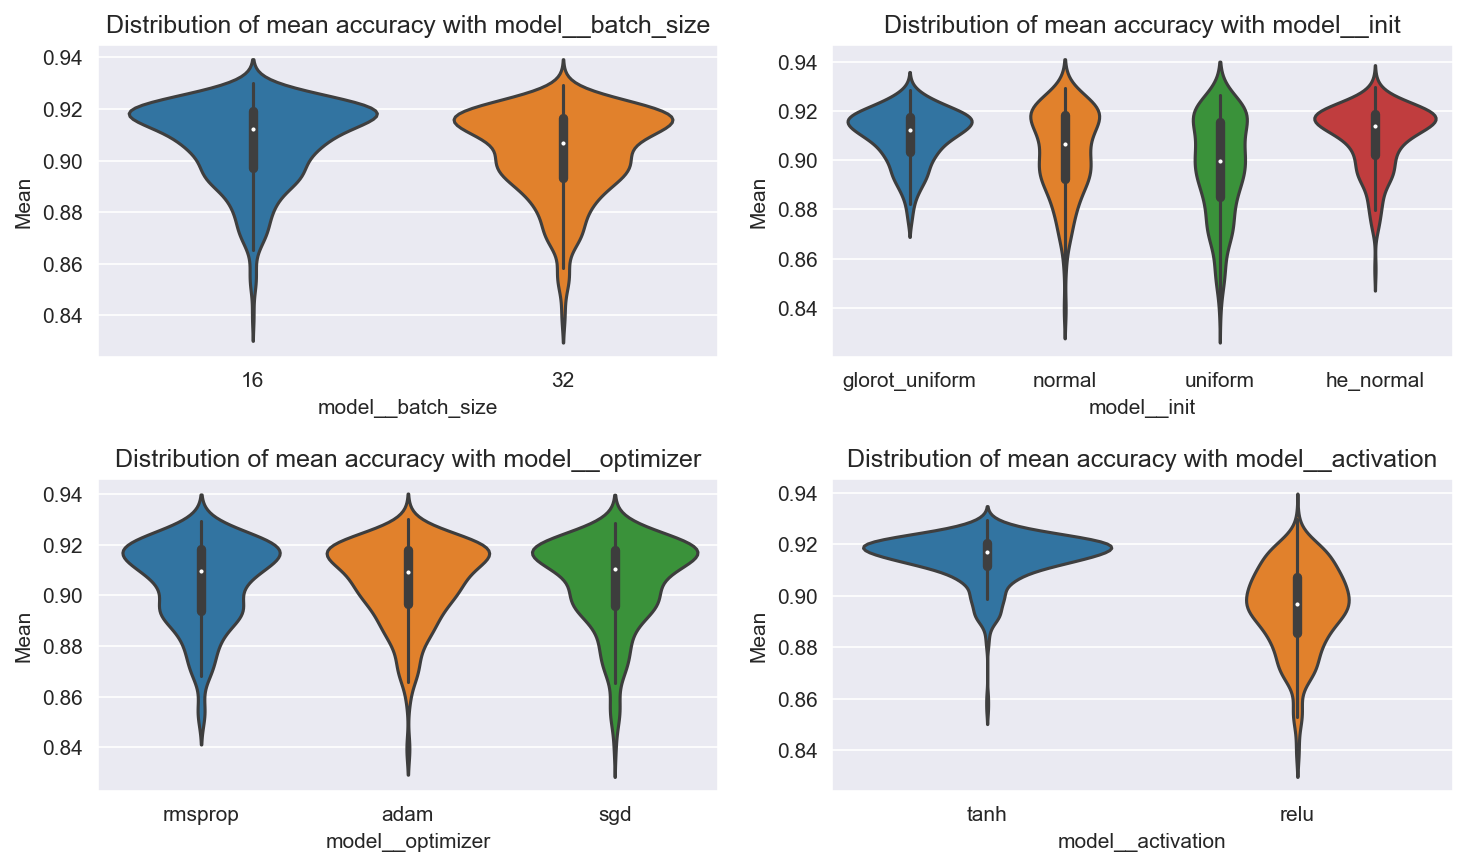

In [29]:
#violin plots of different parameters in gridsearch with accuracy

fig, ax = plt.subplots(2,2,figsize=(10,6), squeeze=False)
ax = ax.ravel()
for i in range(4):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(params_[i]))
    sns.violinplot(x=params_[i],y='Mean',data=d,ax=ax[i])
fig.tight_layout(pad=1.5)

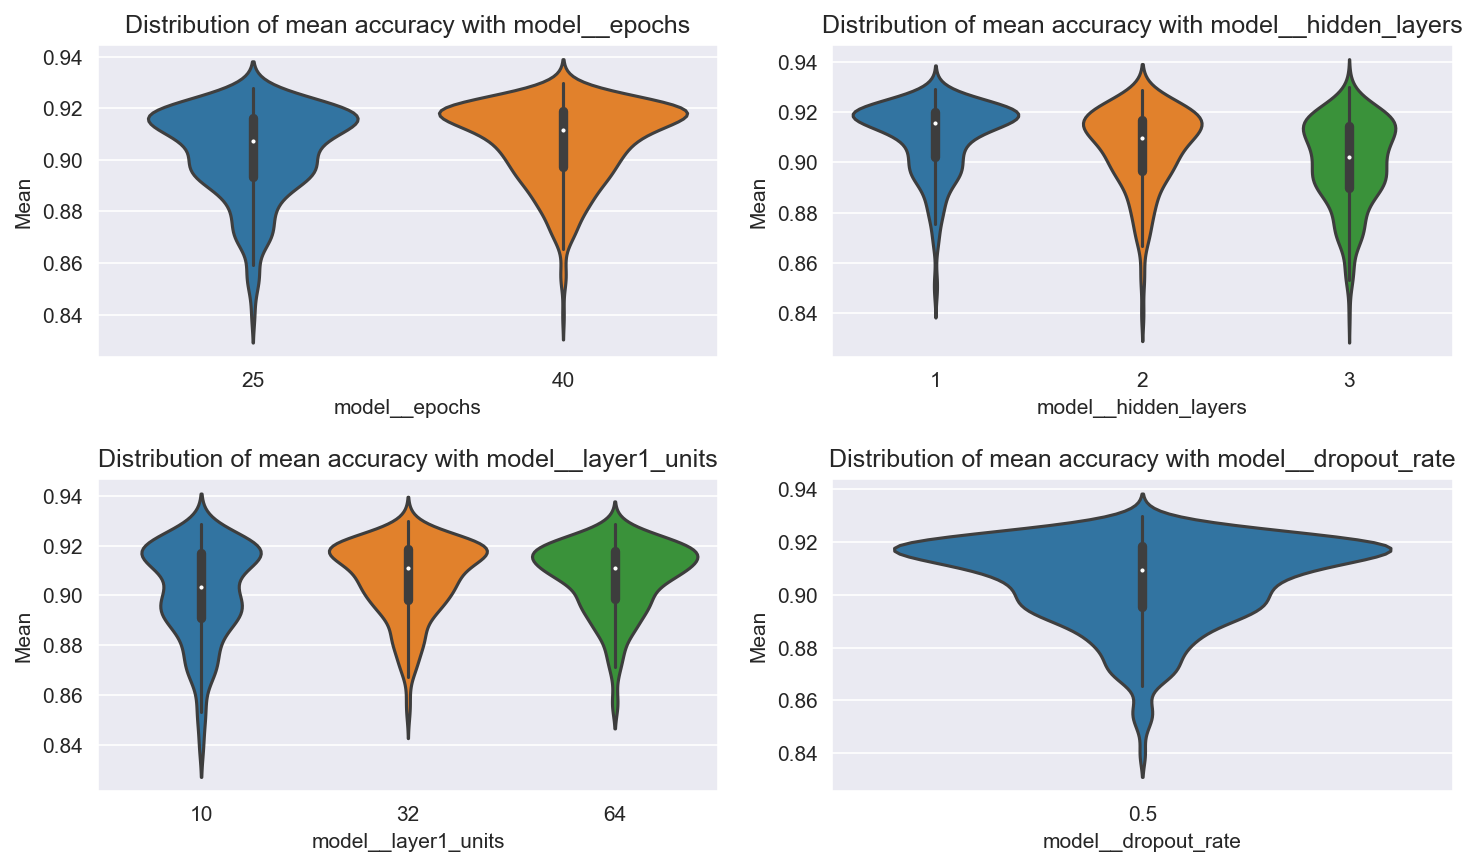

In [47]:
#get remaining parameters to plot
r_params = ['model__epochs','model__hidden_layers','model__layer1_units','model__dropout_rate']

#violin plots 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2,figsize=(10,6), squeeze=False)
ax = ax.ravel()
for i in range(4):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(r_params[i]))
    sns.violinplot(x=r_params[i],y='Mean',data=d,ax=ax[i])
fig.tight_layout(pad=1.5)

In [101]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [33]:
#predict with the best model found
y_pred_keras = grid_result.predict(X_test)

In [37]:
#compute accuracy of predictions
print('\naccuracy: {}%'.format(round(accuracy_score(y_test, y_pred_keras)*100,2)))


accuracy: 92.12%


In [39]:
#evaluation metrics on test set predictions
print('\n',confusion_matrix(y_test, y_pred_keras))
print('\n',classification_report(y_test, y_pred_keras))


 [[306   2   1]
 [ 21  22   0]
 [  1   4  11]]

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       309
         1.0       0.79      0.51      0.62        43
         2.0       0.92      0.69      0.79        16

    accuracy                           0.92       368
   macro avg       0.88      0.73      0.79       368
weighted avg       0.92      0.92      0.91       368



In [ ]:
#make confusion matrix 
cf_matrix = confusion_matrix(y_test, y_pred_keras)

In [ ]:
#script, function for confusion matrix
%run -i show_confusion_matrix.py

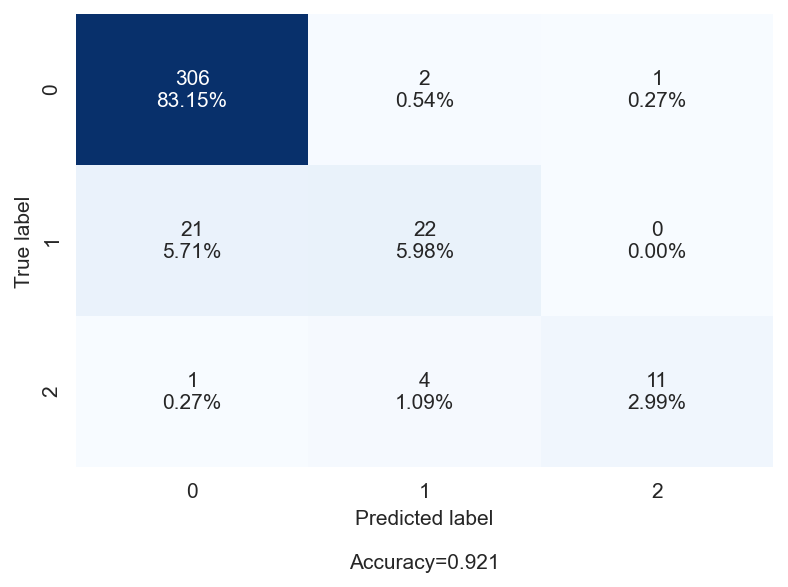

In [45]:
#plot confusion matrix with percentages an numbers
make_confusion_matrix(cf_matrix, figsize=(6,4), cbar=False)